## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from matplotlib import ticker
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
df = pd.read_csv("AZN-AstraZeneca.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845528,4590000
1,2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783760,3948200
2,2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330803,5668200
3,2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083748,2490000
4,2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757298,5283900
...,...,...,...,...,...,...,...
1254,2024-02-23,64.959999,65.930000,64.949997,65.830002,65.830002,7388200
1255,2024-02-26,66.080002,66.370003,65.750000,65.930000,65.930000,4597900
1256,2024-02-27,65.940002,66.459999,65.769997,66.330002,66.330002,4433500
1257,2024-02-28,65.459999,65.779999,65.160004,65.349998,65.349998,6030600


## Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

## Data normalization

In [5]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

## Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:4
train_size = int(0.6 * len(data_scaled))
test_size = len(data_scaled) - train_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Model training and testing

## Training process

In [7]:
# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

In [8]:
# Find the best ARIMA model using auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3570.378, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3554.783, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3567.385, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3566.412, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3556.177, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3564.020, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3563.870, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3559.981, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3560.061, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3565.800, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3570.969, Time=0.83 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3564.224, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-3564.425, Time=1.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3565.927, Time=0.20 sec
 ARIMA(0,1,4)(0,0,0

In [9]:
# Fit the model
model.fit(y_train)

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Validate Processing

## Testing Processing

In [10]:
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)
y_pred = model.predict(n_periods=len(y_test))

## Evaluate Model

In [11]:
# Evaluate the accuracy of test
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
y_pred = scaler.inverse_transform(np.array([y_pred]).reshape(-1, 1))

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.09805970922984186
RMSE on Test dataset:  7.5222909321566975
MSLE on Test dataset:  0.013050090344715116


# Predicting the next 30 days

## Preparing the prediction data

In [12]:
# The process of creating index predict next 30 days
last_index = df_Close.index[-1]

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

## Prediction process

In [13]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))
y_next_30_days = scaler.inverse_transform(np.array([y_next_30_days]).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days.flatten())

Predicted closing prices for the next 30 days:
[60.17507021 60.1638501  60.347094   60.19111391 60.32388662 60.2108684
 60.30707129 60.22518188 60.29488743 60.23555297 60.2860594  60.24306753
 60.27966288 60.24851234 60.27502817 60.25245748 60.27167001 60.255316
 60.26923679 60.2573872  60.26747376 60.25888792 60.26619632 60.25997529
 60.26527073 60.26076317 60.26460007 60.26133404 60.26411414 60.26174768]


## Preparing the forecast date index

In [14]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Visualization

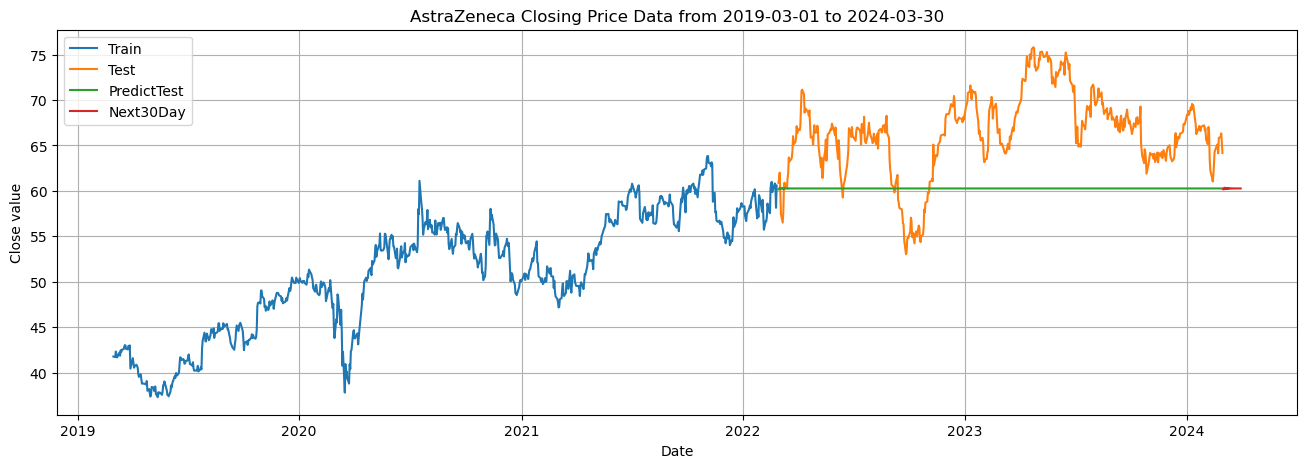

In [15]:
# Drawing
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(np.array([y_train]).reshape(-1, 1)))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Test', 'PredictTest', 'Next30Day'])
plt.grid()
plt.title(f"AstraZeneca Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('image/ARIMA_64_30day_AZN.png')
plt.show()